In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys

In [29]:
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

t=1.0
t_sc=1.0

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(Delta=0.2, salt=13, U0=0.0, gn=0.0, gs=0.0, lam=0.0,
                W=200, L=200, Wsc=80, Lsc=20, t_j=0.1, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

    
    def qh_slab(pos):
        (x, y) = pos 
        if (0 <= x < L) and (0 <= y < W):
            if (int(L/2-Lsc/2)<=x<=int(L/2+Lsc/2) ):
                return y>=Wsc
            else:
                return True
        else:
            return False
        
    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction # does not work with vortex
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        H1=np.kron(H1s,np.eye(2))
        return H1
    
    def onsite(site, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)


    lat = kwant.lattice.honeycomb(norbs=4)
    subA, subB = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (L-1,W-1))] = onsite
    syst[lat.neighbors()] = hopping_ab

    # sc part
    def onsite_sc(site, mu_sc, gs, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    def hopping_sc(site1, site2,lam):
        h1=-t_sc* np.kron(tau_z,np.eye(2))
        xi, yi = site1.pos
        xj, yj = site2.pos
        if np.abs(xj-xi)>0:
            h2=1j*lam* np.kron(tau_z,tau_y)
        else:
            h2=1j*lam* np.kron(np.eye(2),tau_x)
        return h1+h2

    a0=3/(4*sqrt(3))
    b0=0.5
    primitive_vectors = [(b0, 0), (0, a0)]
    lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(0, a0/6),norbs=4)
    Wsq=int(Wsc/a0)
    i_L=int((L/2-Lsc/2)/b0)
    i_R=int((L/2+Lsc/2)/b0)+1
    Lsq=i_R-i_L
    syst[(lat_sc(i, j) for i in range(i_L,i_R) for j in range(Wsq))] = onsite_sc
    syst[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    syst[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    
    # Modify only those hopings on SC-QH bdy
    def hopping_jn(site_i, site_j, t_j):
        return -t_j*np.kron(tau_z,np.eye(2))

    # Manually attach sites from graphene to square lattice
    syst[((lat_sc(i_L, 2*i), subA(int(L/2-Lsc/2)-int(i/2)-1, i)) for i in range(int(Wsq/2)))] = hopping_jn
    syst[((lat_sc(i_L, 2*i+1), subB(int(L/2-Lsc/2)-int(i/2)-1, i)) for i in range(int(Wsq/2)))] = hopping_jn
    syst[((lat_sc(i_R-1, 2*i), subA(int(L/2+Lsc/2)-int(i/2)+(1+(-1)**i)/2, i)) for i in range(int(Wsq/2)))] = hopping_jn
    syst[((lat_sc(i_R-1, 2*i+1), subB(int(L/2+Lsc/2)-int(i/2)+(1+(-1)**i)/2, i)) for i in range(int(Wsq/2)))] = hopping_jn

    Whc=int(2*Wsc/sqrt(3))
    Lhc=int(L/2-Lsc/2-Whc/2)
#     syst[((lat_sc(2*i+i_L, Wsq-1), subB(Lhc+i, Whc)) for i in range(int(Lsq/2)+1))] = hopping_jn
#     syst[((lat_sc(2*i+i_L+1, Wsq-1), subA(Lhc+i, Whc+1)) for i in range(int(Lsq/2)))] = hopping_jn
    syst[((lat_sc(2*i+i_L, Wsq-1), subA(Lhc+i-1, Whc+1)) for i in range(int(Lsq/2)+1))] = hopping_jn
    syst[((lat_sc(2*i+i_L+1, Wsq-1), subB(Lhc+i, Whc)) for i in range(int(Lsq/2)))] = hopping_jn
          
    
    # leads
    def onsite_lead(site, mu_lead):
        return  (4*t- mu_lead)* np.kron(tau_z,np.eye(2))

    def hopping_lead(site1, site2):
        return -t*np.kron(tau_z,np.eye(2))

    # honeycomb leads
# #     c1=-np.kron(np.eye(2),tau_z)
# #     c1=-np.kron(tau_z,np.eye(2))
#     c1 = np.diag([-2, -1, 1, 2])
#     sym_left = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
#     left_lead = kwant.Builder(sym_left, conservation_law=c1, particle_hole=np.kron(tau_x,np.eye(2)) )
#     L_lead=int(W/(sqrt(3)/2))
#     left_lead[(subA(0,y) for y in range(L_lead+1))] = onsite_lead
#     left_lead[(subB(0,y) for y in range(L_lead))] = onsite_lead
#     left_lead[lat.neighbors()] = hopping_ab
#     syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())
    
    # square leads
    Wsys=int(W/a0)
    Lsys=int(L/b0)
    syst[(lat_sc(-1, i) for i in range(Wsys))] = onsite_lead
    syst[((lat_sc(-1, i), lat_sc(-1, i+1)) for i in range(Wsys-1))] = hopping_lead
    syst[((lat_sc(-1, 2*i), subA(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
    syst[((lat_sc(-1, 2*i+1), subB(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
    syst[(lat_sc(Lsys, i) for i in range(Wsys))] = onsite_lead
    syst[((lat_sc(Lsys, i), lat_sc(Lsys, i+1)) for i in range(Wsys-1))] = hopping_lead
    syst[((lat_sc(Lsys, 2*i), subA(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
    syst[((lat_sc(Lsys, 2*i+1), subB(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead

###     # square leads
    claw = np.diag([-2, -1, 1, 2])
    sym_left = kwant.TranslationalSymmetry(lat_sc.vec((-1, 0)))
    left_lead = kwant.Builder(sym_left, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
    left_lead[(lat_sc(0,y) for y in range(Wsys))] = onsite_lead
    left_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_lead
    left_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_lead
    syst.attach_lead(left_lead)
    syst.attach_lead(left_lead.reversed())

    # modify the lower edge of the sample
    syst[(lat_sc(i, -1) for i in range(i_L,i_R))] = onsite_sc
    syst[((lat_sc(i, -1), lat_sc(i+1, -1)) for i in range(i_L,i_R-1))] = hopping_sc
    syst[((lat_sc(i, -1), lat_sc(i, 0)) for i in range(i_L,i_R))] = hopping_sc

    sym_bottom = kwant.TranslationalSymmetry(lat_sc.vec((0, -1)))
    bottom_lead = kwant.Builder(sym_bottom, particle_hole=np.kron(tau_x,np.eye(2)))
    bottom_lead[(lat_sc(x, 0) for x in range(i_L,i_R))] = onsite_sc
    bottom_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    bottom_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    syst.attach_lead(bottom_lead)
    
    return syst

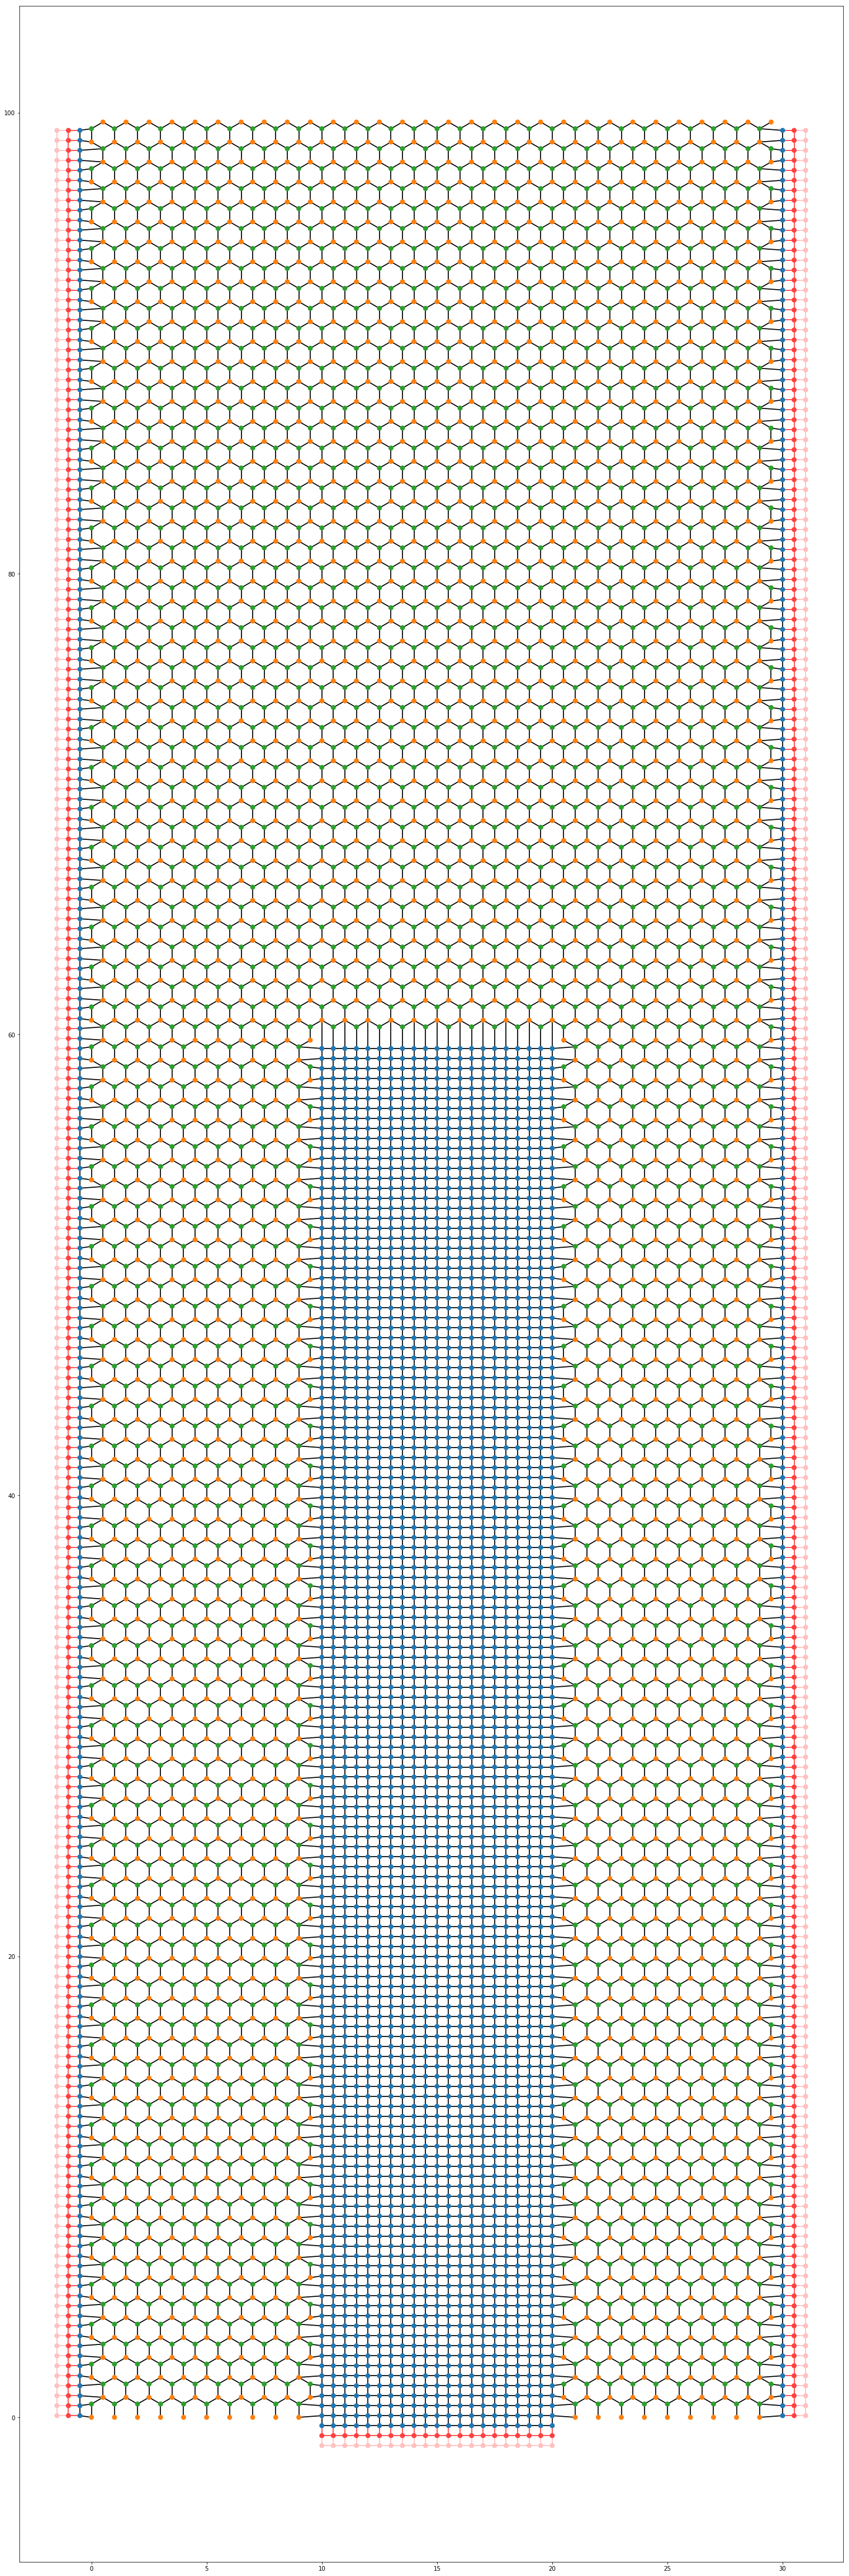

In [30]:
# Wsc must be multiples of eight
Wsc=60
W=Wsc+40
Lsc=10
L=Lsc+20
syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(40,80))
# kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

(232, 35396)


/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: The plotted data contains 1.56% of values overflowing upper limit 0.0264718 


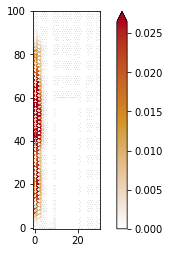

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: The plotted data contains 1.81% of values overflowing upper limit 7.59044e-05 


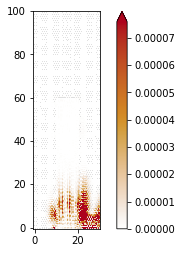

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: The plotted data contains 1.90% of values overflowing upper limit 0.000134495 


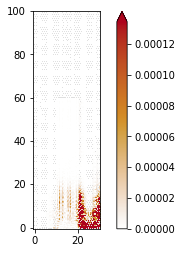

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: The plotted data contains 1.63% of values overflowing upper limit 5.42932e-05 


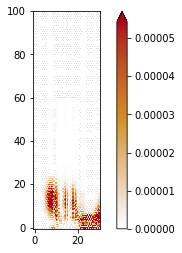

In [31]:
mu=0.5
mu_lead=0.6
mu_sc=1.5
phi=0.05
U0=0.0 # disorder strength
salt=13
Delta=0.06
t_j=0.6
gs=0.
gn=0.2
lam=0.4

energy=0.*Delta
params=dict(t_j=t_j, gn=gn, lam=lam, gs=gs, Delta=Delta, mu_lead=mu_lead ,mu=mu-gn,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,::2])**2, axis=0)-np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
print(scattering_wf.shape)
ind=0
# fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, sharey=True, figsize=(12, 4))
# kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2-abs(scattering_wf[ind,3::4])**2,ax=ax1);
# kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2-abs(scattering_wf[ind,2::4])**2,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2)#,vmax=0.7);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2)#,vmax=0.1);#,ax=ax3);
kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax4);

In [32]:
def compute_conductance(syst, energies, params):
    # Compute conductance
    Pe = np.zeros((4,len(energies)))
#     Pe = np.zeros(len(energies))
#     Ph = np.zeros(len(energies))
    for i_e in range(len(energies)):
        print(i_e, end='\r')
        energy=energies[i_e]
        smatrix = kwant.smatrix(syst, energy=energy,params=params)
        for i in range(4):
            Pe[i,i_e]=smatrix.transmission((1, i), (0, 0))
#         Pe[i_e]=smatrix.transmission((1, 0), (0, 0))                     
#         Ph[i_e]=smatrix.transmission((1, 2), (0, 0)) 
#         wfs = kwant.wave_function(syst, energy=energy, params=params)
#         if i_e==0:
#             # construct the wf array to be saved
#             wf_arr=np.zeros((wfs(0).shape[0],wfs(0).shape[1],len(energies)),dtype=np.complex64)
        
#         wf_arr[:,:,i_e]= wfs(0)
#     return Pe, Ph, wf_arr
    return Pe


# Compute and plot the conductance
E_list=np.arange(-10, 11)*0.1*Delta
t_timer=time.time()
# Compute and plot the conductance
# Pe, Ph, wf_arr= compute_conductance(syst, energies=[E for E in E_list], params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt) )
Pe = compute_conductance(syst, energies=[E for E in E_list], params=params )
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")


Finished, elapsed time = 292 sec


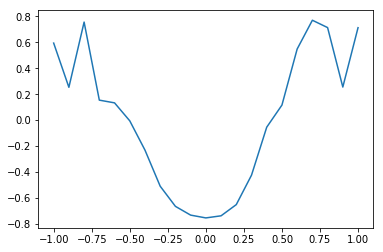

In [34]:
plt.figure()
# plt.plot(E_list/Delta, Pe.T)
# plt.legend((r'$e_\uparrow$', r'$e_\downarrow$', r'$h_\uparrow$', r'$h_\downarrow$'))
# plt.xlabel("energy [Delta]")
# plt.ylabel(r"$P_e - P_h$")
P_diff=Pe[0,:]+Pe[1,:]-Pe[2,:]-Pe[3,:]
plt.plot(E_list/Delta, P_diff.T)
plt.show()